In [1]:
import requests
import base64
import os
import json
from flask import Flask
import urllib.parse 
import pandas as pd
from IPython.display import Image, display, HTML
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def extract_spotify_url(external_urls):
    return external_urls['spotify']
    
def make_clickable(link):
    return f'<a href="{link}" target="_blank">{link}</a>'

https://developer.spotify.com/documentation/web-api/tutorials/getting-started

discography_data_frame2.to_csv('discography_data.csv', mode='a', header=False, index=False)

In [3]:
def get_spotify_access_token(client_id, client_secret):
    url = 'https://accounts.spotify.com/api/token'
    headers = {
        'Authorization': 'Basic ' + base64.b64encode(f'{client_id}:{client_secret}'.encode()).decode()
    }
    data = {
        'grant_type': 'client_credentials'
    }
    
    try:
        response = requests.post(url, headers=headers, data=data)
        response.raise_for_status()  # Solleva un'eccezione se la richiesta HTTP non ha successo
        token_data = response.json()
        
        if 'access_token' in token_data:
            return token_data['access_token']
        else:
            raise Exception(f"Errore nell'ottenere il token di accesso: {token_data.get('error', 'Errore sconosciuto')}")
            
    except requests.exceptions.RequestException as e:
        raise Exception(f"Errore nella richiesta HTTP: {e}")

In [4]:
def search_artist(token, artist_name):
    url = "https://api.spotify.com/v1/search"
    headers = {
        "Authorization": f"Bearer {token}"
    }
    params = {
        "q": artist_name,
        "type": "artist",
        "limit": 1
    }
    
    try:
        response = requests.get(url, headers=headers, params=params)
        response.raise_for_status()  # Solleva un'eccezione se la richiesta HTTP non ha successo
        data = response.json()
        artists = data.get("artists", {}).get("items", [])
        
        if artists:
            return artists[0]
        else:
            print(f"Nessun artista trovato con il nome '{artist_name}'.")
            return None
            
    except requests.exceptions.RequestException as e:
        print(f"Errore nella richiesta HTTP: {e}")
        return None

In [5]:
def get_albums(token, artist_id):
    url = f'https://api.spotify.com/v1/artists/{artist_id}/albums'
    
    headers = {
        "Authorization": f"Bearer {token}"
    }
    params = {
        "market": "IT"
    }

    try:
        response = requests.get(url, headers=headers, params=params)
        response.raise_for_status()  # Solleva un'eccezione se la richiesta HTTP non ha successo
        data = response.json()
        
        return data.get("items", [])
        
    except requests.exceptions.RequestException as e:
        print(f"Errore nella richiesta HTTP: {e}")
        return []

In [6]:
def get_album_tracks(token, album_id):
    url = f'https://api.spotify.com/v1/albums/{album_id}/tracks'
    
    headers = {
        "Authorization": f"Bearer {token}"
    }
    params = {
        "market": "IT"
    }

    try:
        response = requests.get(url, headers=headers, params=params)
        response.raise_for_status()  # Solleva un'eccezione se la richiesta HTTP non ha successo
        data = response.json()
        
        return data.get("items", [])
        
    except requests.exceptions.RequestException as e:
        print(f"Errore nella richiesta HTTP: {e}")
        return []

In [7]:
def top_tracks_artist(token, artist_id):
    url = f"https://api.spotify.com/v1/artists/{artist_id}/top-tracks?country=IT"
    headers = {
        "Authorization": f"Bearer {token}"
    }
    
    try:
        response = requests.get(url, headers=headers)
        response.raise_for_status()  
        data = response.json()["tracks"]
        return data
        
    except requests.exceptions.RequestException as e:
        print(f"Errore nella richiesta HTTP: {e}")
        return None

In [8]:
def get_artist_related(token, id):
    url = f"https://api.spotify.com/v1/artists/{id}/related-artists"
    headers = {
        "Authorization": f"Bearer {token}"
    }

    try:
        response = requests.get(url, headers=headers)
        response.raise_for_status() 
        data = response.json()["artists"]
        return data
    except requests.exceptions.RequestException as e:
        print(f"Errore nella richiesta HTTP: {e}")
        return None

## Testing delle funzioni realizzate

In [9]:
client_id = 'cd0f7e9279034469a5c4560808cb31a8' 
client_secret = 'da3fe74efc5c4a84b71399c157366e09'
access_token = get_spotify_access_token(client_id, client_secret) # ottengo il token di accesso

print(f"Token di accesso: {access_token}")

Token di accesso: BQC7kHED4BpZlI2uQWCheFqsTanMHAGtuCxxeaSxVXMAgzIEY8a2utkNladJxVdZTnWiZ6gN0feMiHM7kCq1lv6rEOa628tSbhlnWBd7PXFj66bg4x0


In [10]:
artist_name = "Emis Killa" 
artist = search_artist(access_token, artist_name) # ottengo l'artista

artist_data = {
    "name": artist["name"],
    "id": artist["id"] ,
    "genres": artist["genres"][0],
    "popularity": artist["popularity"],
    "followers": artist["followers"]["total"],
    "uri" : artist["uri"],
    "external_urls": artist["external_urls"]["spotify"],
    "images_url": artist["images"][0]["url"]
}

pd.set_option('display.max_colwidth', 1)
artist_data_frame = pd.DataFrame([artist_data])
artist_data_frame['external_urls'] = artist_data_frame['external_urls'].apply(make_clickable)

print(f"Artista trovato: {artist_name} (ID: {artist_data['id']})\n") 

# Visualizza l'immagine centrata
image_html = f'<div style="display: flex; justify-content: center;">' \
             f'<img src="{artist_data_frame["images_url"][0]}" alt="Artista" width="{250}" style="display: block;"/>' \
             f'</div>'
artist_data_frame = artist_data_frame.drop("images_url", axis=1)

display(HTML(artist_data_frame.to_html(escape=False)))
display(HTML(image_html))

Artista trovato: Emis Killa (ID: 6FtwCmLY6L1sqvjaQ2lV6G)



,name,id,genres,popularity,followers,uri,external_urls
0,Emis Killa,6FtwCmLY6L1sqvjaQ2lV6G,italian hip hop,62,1547442,spotify:artist:6FtwCmLY6L1sqvjaQ2lV6G,https://open.spotify.com/artist/6FtwCmLY6L1sqvjaQ2lV6G


In [11]:
artist_albums = get_albums(access_token, artist_data['id']) # ottengo gli album dell'artista
album_data_frame = pd.DataFrame(artist_albums, columns=['name','id','release_date','total_tracks','images','external_urls'])
album_data_frame['images'] = album_data_frame['images'].apply(lambda x: f'<img src="{x[0]["url"]}" alt="Album Cover" style="max-height: 50px; max-width: 50px;">')
album_data_frame = album_data_frame[album_data_frame["total_tracks"] != 1]

album_data_frame['external_urls'] = album_data_frame['external_urls'].apply(extract_spotify_url)
album_data_frame['external_urls'] = album_data_frame['external_urls'].apply(make_clickable)

print(f"Gli album dell'artista {artist_name} sono:\n")
display(HTML(album_data_frame.to_html(escape=False)))

Gli album dell'artista Emis Killa sono:



,name,id,release_date,total_tracks,images,external_urls
0,Effetto notte,39wuRno08Rl0Jsse2kCHga,2023-05-19,14,,https://open.spotify.com/album/39wuRno08Rl0Jsse2kCHga
1,L'erba cattiva (10 Years Anniversary Edition),53qzcXW1K4TdnJZUp0Ftpu,2022-12-09,15,,https://open.spotify.com/album/53qzcXW1K4TdnJZUp0Ftpu
2,"Keta Music, Vol. 3",5XmLyPktaR9fYxYqtQukqa,2021-07-23,11,,https://open.spotify.com/album/5XmLyPktaR9fYxYqtQukqa
3,17 - Dark Edition,6nKQCH9bP1APHf83iDCjO2,2021-02-26,24,,https://open.spotify.com/album/6nKQCH9bP1APHf83iDCjO2
4,17,11T8pkk7VAT7LeoReyY7B7,2020-09-18,17,,https://open.spotify.com/album/11T8pkk7VAT7LeoReyY7B7
5,Supereroe Bat Edition,3YdgMr7sbDBeuPotzWJz60,2019-06-21,17,,https://open.spotify.com/album/3YdgMr7sbDBeuPotzWJz60
6,Supereroe,67g3eUjlYFB7EkhS1pjKe4,2018-10-12,13,,https://open.spotify.com/album/67g3eUjlYFB7EkhS1pjKe4
7,Terza Stagione,2goDKoHetJSDYCxZq9h17h,2016-10-14,17,,https://open.spotify.com/album/2goDKoHetJSDYCxZq9h17h
8,Keta Music - Volume 2,2P8Ga6LVlc6lwuKwxsrbsd,2015-06-18,13,,https://open.spotify.com/album/2P8Ga6LVlc6lwuKwxsrbsd
9,Mercurio - 5 Stars Edition,5ZPw8Dc0rcfLBlJj9zJ9pK,2014-06-10,19,,https://open.spotify.com/album/5ZPw8Dc0rcfLBlJj9zJ9pK


In [12]:
album_name = "Effetto notte"  
album_id = album_data_frame.loc[album_data_frame['name'] == album_name, 'id'].values[0]
album_tracks = get_album_tracks(access_token, album_id)
tracks_data_frame = pd.DataFrame(album_tracks, columns=['name','id','duration_ms','external_urls'])

tracks_data_frame['duration_ms'] = tracks_data_frame['duration_ms'] / 60000
tracks_data_frame['duration_ms'] = tracks_data_frame['duration_ms'].round(2)

tracks_data_frame['external_urls'] = tracks_data_frame['external_urls'].apply(extract_spotify_url)
tracks_data_frame['external_urls'] = tracks_data_frame['external_urls'].apply(make_clickable)
tracks_data_frame = tracks_data_frame.rename(columns={'external_urls':'spotify_url'})

print(f"Le tracce dell'album {album_name} sono:\n")
display(HTML(tracks_data_frame.to_html(escape=False)))

Le tracce dell'album Effetto notte sono:



,name,id,duration_ms,spotify_url
0,PACINO - the godfather,0DJJkaSRugtaqVjWOItGn0,2.04,https://open.spotify.com/track/0DJJkaSRugtaqVjWOItGn0
1,ON FIRE - paid in full,2pGbOFiWVwZaTq3iKi5sGb,2.93,https://open.spotify.com/track/2pGbOFiWVwZaTq3iKi5sGb
2,COL CUORE IN GOLA - lords of dogtown,2ypcWaliFPJ9c3JeWMqi1w,3.14,https://open.spotify.com/track/2ypcWaliFPJ9c3JeWMqi1w
3,VISCERALE - closer,7bgJm5Z7EpvXRMdysiUjCj,3.07,https://open.spotify.com/track/7bgJm5Z7EpvXRMdysiUjCj
4,MASERATI - the wolf of wall street,3vZ3ZCdyr7jxBDKzgFtKBN,2.27,https://open.spotify.com/track/3vZ3ZCdyr7jxBDKzgFtKBN
5,LONTANO - carlito's way,2t1dculU2L9HxEIzB00Xpk,2.78,https://open.spotify.com/track/2t1dculU2L9HxEIzB00Xpk
6,ALBICOCCA - lolita,1Bkq1PP6QZrZcpAyEnIKDy,2.71,https://open.spotify.com/track/1Bkq1PP6QZrZcpAyEnIKDy
7,BIG BANG - upside down,6IMdD50UNZOZxGro2bgsnN,3.30,https://open.spotify.com/track/6IMdD50UNZOZxGro2bgsnN
8,TOXIC - trainspotting,3mrtP5imQ3Mv3OQ0byI4ix,3.00,https://open.spotify.com/track/3mrtP5imQ3Mv3OQ0byI4ix
9,SONNY - city of god,3knzVyYsKLWzlzdBiZPHWB,3.18,https://open.spotify.com/track/3knzVyYsKLWzlzdBiZPHWB


In [13]:
top_tracks = top_tracks_artist(access_token, artist_data['id'])

top_tracks_data_frame = pd.DataFrame([{
    'title': track['name'],
    'duration': f"{track['duration_ms'] // 60000}:{(track['duration_ms'] % 60000) // 1000:02d}",
    'album' : track["album"]["name"],
    'spotify_url': track['external_urls']['spotify']
} for track in top_tracks])
top_tracks_data_frame['spotify_url'] = top_tracks_data_frame['spotify_url'].apply(make_clickable)

print(f"Top Tracks dell'artista {artist_name} :\n")
display(HTML(top_tracks_data_frame.to_html(escape=False)))

Top Tracks dell'artista Emis Killa :



,title,duration,album,spotify_url
0,ON FIRE - paid in full,2:56,Effetto notte,https://open.spotify.com/track/2pGbOFiWVwZaTq3iKi5sGb
1,SENZ'ANIMA - nikita,3:13,Effetto notte,https://open.spotify.com/track/39ZJEJ8KLq8yQQ1OEAdJ1W
2,Fuoco e benzina,3:29,Supereroe,https://open.spotify.com/track/4Fs1sEg9Mwn6vykFD89xvc
3,Mon Fre - feat. Emis Killa,3:44,Mon Fre (feat. Emis Killa),https://open.spotify.com/track/4dDMgEj5GpBTI1lvVlYPu7
4,Parole di ghiaccio,3:51,L'erba cattiva,https://open.spotify.com/track/1mItEeAlTepKfWUOpu8h6b
5,Rollercoaster,3:27,Supereroe,https://open.spotify.com/track/4WJj8NsyCm3YAADCOe0hrf
6,"PAROLA - feat. Lazza, Emis Killa",3:23,CHIC,https://open.spotify.com/track/4XxQOwmNM0DF3bKafSJBNw
7,L'ultima volta - feat. Massimo Pericolo,3:30,17,https://open.spotify.com/track/3rOw9WmYFCRLHTRcbOjhUl
8,No Cap (feat. Geolier),3:13,17 - Dark Edition,https://open.spotify.com/track/3uqFFmxrCv4nzkKFSNbXHv
9,Quella foto di noi due,3:14,Supereroe,https://open.spotify.com/track/10hc6GvyWhe2E48PAfQrdD


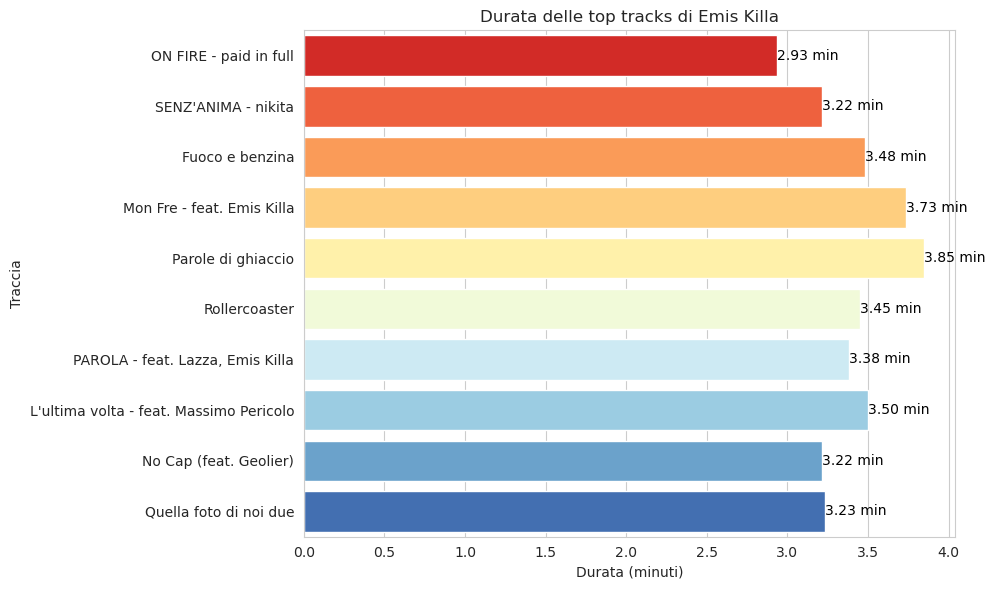

In [14]:
# Grafico la durata delle top tracks dell'artista

# Estrai la durata delle tracce (in minuti) dal dataframe
durations = top_tracks_data_frame['duration'].str.split(':').apply(lambda x: int(x[0]) + int(x[1]) / 60)

# Imposta uno stile di sfondo chiaro
sns.set_style("whitegrid")

# Crea una palette di colori graduati
custom_palette = sns.color_palette("RdYlBu", n_colors=len(durations))

# Crea un grafico a barre orizzontali con la nuova palette di colori
plt.figure(figsize=(10, 6))
barplot = sns.barplot(x=durations, y=top_tracks_data_frame['title'], hue=top_tracks_data_frame['title'], palette=custom_palette, saturation=1)

# Aggiungi il valore della durata a destra delle barre
for bar, duration in zip(barplot.patches, durations):
    plt.text(bar.get_width(), bar.get_y() + bar.get_height() / 2, f'{duration:.2f} min', ha='left', va='center', fontsize=10, color='black')

plt.xlabel('Durata (minuti)')
plt.ylabel('Traccia')
plt.title(f'Durata delle top tracks di {artist_name}')
plt.tight_layout()

plt.show()

In [15]:
artists = get_artist_related(access_token, artist_data['id'])

artists_data = pd.DataFrame([{
    'name' : artist["name"],
    'id': artist['id'],
    'genres': artist['genres'][0],
    'popularity': artist['popularity'],
    'followers' : artist["followers"]["total"],
    'external_urls': artist['external_urls']['spotify'],
    'image' : f'<img src="{artist["images"][0]["url"]}" width="60" height="60">'
} for artist in artists])

artists_data_frame = pd.DataFrame(artists_data)
artists_data_frame['external_urls'] = artists_data_frame['external_urls'].apply(make_clickable)
artists_data_frame = artists_data_frame.sort_values(by='followers',ascending=False)
artists_data_frame= artists_data_frame.reset_index(drop=True)

print(f'Artisti correlati:\n')
display(HTML(artists_data_frame.to_html(escape=False)))

Artisti correlati:



,name,id,genres,popularity,followers,external_urls,image
0,Guè,7F2utINZ6tSokSiZTQBE27,italian hip hop,72,2348000,https://open.spotify.com/artist/7F2utINZ6tSokSiZTQBE27,
1,Gemitaiz,4upwdFMlZBmQ68jP9jPzjK,italian hip hop,64,2066620,https://open.spotify.com/artist/4upwdFMlZBmQ68jP9jPzjK,
2,Tedua,1AgAVqo74e2q4FVvg0xpT7,indie liguria,70,1571291,https://open.spotify.com/artist/1AgAVqo74e2q4FVvg0xpT7,
3,Dark Polo Gang,4CuMwzDzEdlUJMEna38VQ0,italian hip hop,54,1359626,https://open.spotify.com/artist/4CuMwzDzEdlUJMEna38VQ0,
4,MadMan,3MkkSf3u5KU52Mb2iMrqeX,italian hip hop,58,1222591,https://open.spotify.com/artist/3MkkSf3u5KU52Mb2iMrqeX,
5,Vegas Jones,4b3MWJACM6T1QwGKoFe7pp,italian hip hop,50,937824,https://open.spotify.com/artist/4b3MWJACM6T1QwGKoFe7pp,
6,Izi,6289Bbkkk3gaCbh1K7Rv8F,indie liguria,57,918605,https://open.spotify.com/artist/6289Bbkkk3gaCbh1K7Rv8F,
7,Ernia,3fhMfkPPzksWuw0hEm4ldm,italian hip hop,64,872895,https://open.spotify.com/artist/3fhMfkPPzksWuw0hEm4ldm,
8,Noyz Narcos,49UAapOfpOg1ZOU4xf2NgY,italian hip hop,69,764722,https://open.spotify.com/artist/49UAapOfpOg1ZOU4xf2NgY,
9,Nitro,6jQZzWW3JlEtcRDSzFVKSP,italian hip hop,59,673902,https://open.spotify.com/artist/6jQZzWW3JlEtcRDSzFVKSP,


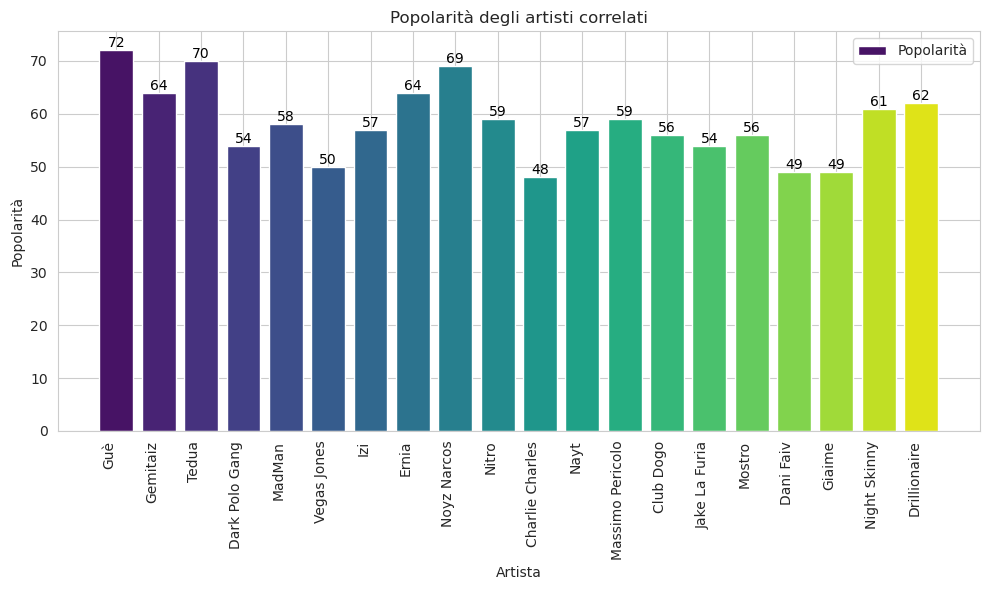

In [16]:
# Imposta uno stile di sfondo chiaro
sns.set_style("whitegrid")

# Crea un grafico a barre orizzontali con colori personalizzati
plt.figure(figsize=(10, 6))
colors = sns.color_palette("viridis", len(artists_data_frame))
barplot = plt.bar(artists_data_frame['name'], artists_data_frame['popularity'], color=colors)

# Aggiungi il valore della popolarità sopra le barre
for bar, popularity in zip(barplot, artists_data_frame['popularity']):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), popularity, ha='center', va='bottom', fontsize=10, color='black')

plt.xticks(rotation=90, ha='right')
plt.xlabel('Artista')
plt.ylabel('Popolarità')
plt.title('Popolarità degli artisti correlati')
plt.tight_layout()

# Aggiungi una legenda
legend_labels = ['Popolarità']
plt.legend(legend_labels, loc='upper right')

plt.show()

In [17]:
import requests
import datetime
from flask import Flask, redirect, session, request , jsonify , render_template
import urllib.parse
from datetime import datetime , timedelta
import secrets
from base64 import b64encode

state = secrets.token_urlsafe(16)  # Genera un valore casuale per state

REDIRECT_URI = "http://localhost:5000/callback"
TOKEN_URL = "https://accounts.spotify.com/api/token"
AUTH_URL = "https://accounts.spotify.com/authorize"
API_BASE_URL = "https://api.spotify.com/v1/"

app = Flask(__name__, static_url_path='/static')
app.secret_key = '1299213929x9sdasd9asdsa-2919293'  # You should set your own secret key

#decoratore definisce una route per url di base -> applicazione aperta viene eseguita la funzione index
@app.route('/')
def index():
    return render_template('index.html')

@app.route('/login')
def login():
    scope= 'user-read-private user-read-email'
    #scope -> permessi che l'utente deve accettare per andare avanti
    params = { 
            'client_id' : client_id,
            'response_type' : 'code',
            'scope' : scope,
            'redirect_uri' : REDIRECT_URI, #dove viene indirizzato dopo aver avuto accesso/negato l'autorizzazione
            'show_dialog' : True,
            'state' : state
    }

    auth_url = f"{AUTH_URL}?{urllib.parse.urlencode(params)}"
    print(auth_url)
    return redirect(auth_url)

#questa funzione gestisce la risposta di spotify dopo che l'utente ha accettato l'autorizzazione
@app.route('/callback')
def callback():
    print(request.args)
    if 'error' in request.args:
        return  request.args["error"]

    if 'code' in request.args:
        req_body = {
            'code': request.args["code"],
            'grant_type': 'authorization_code',
            'redirect_uri' : REDIRECT_URI, #dove viene indirizzato dopo aver avuto accesso/negato l'autorizzazione
            'client_id' : client_id,
            'client_secret': client_secret
        }
    
        response = requests.post(TOKEN_URL, data=req_body)
        token_info = response.json()
        print(token_info)
        session['access_token'] = token_info.get('access_token')
        session['refresh_token'] = token_info.get('refresh_token')
        session['expires_at'] = datetime.now().timestamp() + token_info.get('expires_in', 3600)  # Set an appropriate expiration time
        return redirect('/home')

    return "Invalid callback request"

@app.route('/home')
def get_home():
    if 'access_token' not in session:
        return redirect('/login')

    if datetime.now().timestamp() > session['expires_at']:
        print("TOKEN EXPIRED")
        return redirect('/refresh-token')

    headers = {
        'Authorization' : f"Bearer {session['access_token']}"
    }
    
    page_content = "<form action='/playlists' method='get'>"
    page_content += "<button type='submit'>Playlist</button>"
    page_content += "</form>"

    page_content1 = "<form action='/playlists' method='get'>"
    page_content1 += "<button type='submit'>PULSANTE 2</button>"
    page_content1 += "</form>"

    return page_content

@app.route('/playlists')
def get_playlists():
    if 'access_token' not in session:
        return redirect('/login')

    if datetime.now().timestamp() > session['expires_at']:
        print("TOKEN EXPIRED")
        return redirect('/refresh-token')

    headers = {
        'Authorization' : f"Bearer {session['access_token']}"
    }

    response = requests.get(API_BASE_URL + 'me/playlists', headers=headers)
    playlists = response.json()

    return jsonify(playlists)

@app.route('/refresh-token')
def refresh_token():
    if 'refresh_token' not in session:
        return redirect('/login')
    
    if datetime.now().timestamp() > session['expires_at']:
        req_body = {
            'grant_type': 'refresh_token', 
            'refresh_token': session['refresh_token'],
            'client_id': client_id,
            'client_secret': client_secret
        }

        response = requests.post(TOKEN_URL, data=req_body)
        new_token_info = response.json()

        session['access_token'] = new_token_info['access_token']
        session['expires_at'] = datetime.now().timestamp() + 10

        return redirect('/playlists')

if __name__ == '__main__'  :
    app.run(port=5000)

### Procedura di autanticazione Oauth2 per Spotify

In [19]:
import requests
import urllib.parse
import secrets
from datetime import datetime
import json

REDIRECT_URI = "http://localhost:5000/callback"
TOKEN_URL = "https://accounts.spotify.com/api/token"
AUTH_URL = "https://accounts.spotify.com/authorize"
API_BASE_URL = "https://api.spotify.com/v1/"

state = secrets.token_urlsafe(16) 

scope = 'user-read-private user-top-read user-read-email user-follow-read playlist-modify-private playlist-modify-public user-follow-modify user-library-read'
params = {
    'client_id': client_id,
    'response_type': 'code',
    'scope': scope,
    'redirect_uri': REDIRECT_URI,
    'show_dialog': True,
    'state': state
}

auth_url = f"{AUTH_URL}?{urllib.parse.urlencode(params)}"
print(f'Vai a questa URL e autorizza l\'app: {auth_url}')
callback_url = input("Incolla l'URL della pagina qui: ")
url_components = urllib.parse.urlparse(callback_url)
query_params = urllib.parse.parse_qs(url_components.query)
authorization_code = query_params.get('code')

req_body = {
    'code': authorization_code,
    'grant_type': 'authorization_code',
    'redirect_uri': REDIRECT_URI,
    'client_id': client_id,
    'client_secret': client_secret
}

response = requests.post(TOKEN_URL, data=req_body)
token_info = response.json()
access_token = token_info.get('access_token')
refresh_token = token_info.get('refresh_token')
expires_at = datetime.now().timestamp() + token_info.get('expires_in', 3600)

headers = {
    'Authorization': f'Bearer {access_token}'
}

Vai a questa URL e autorizza l'app: https://accounts.spotify.com/authorize?client_id=cd0f7e9279034469a5c4560808cb31a8&response_type=code&scope=user-read-private+user-top-read+user-read-email+user-follow-read+playlist-modify-private+playlist-modify-public+user-follow-modify+user-library-read&redirect_uri=http%3A%2F%2Flocalhost%3A5000%2Fcallback&show_dialog=True&state=IgVChcy965vVhvtmPLJD3A


Incolla l'URL della pagina qui:  http://localhost:5000/callback?code=AQDzAdE8imnWXcMAF__9_VfoLJENAxV2XyHaxHrW2PKXz3l9yPiy3gDgYEOr9YupivdAEYT9q6UHrr9hkvjtRIflKnJZhh-Cl56_cEHPoQi7qsm8TujECba5PJB9pVQJO994BobWpIn8lNPjp0qLMQhKvyj6yWCpObtze5lunet_1AnZDssCjykOoUA7FvyRRopHyo-XonPbv0V_vUTYlNK1Sin611bbnCqnk7WHYq1IZr9FZUK282eYj0mgCk72vU-M82lZmIPSZYpOUqLyOjSVjftRDQ2UefjMmtHVVk9RqwQtY-E6eEp-oKZGtDhYwdPvn2lK9dgW6kFqerGaRaIn-9a8nB3cjGOqwncXR6vkt5mkdRs1g_WXVCJBmQc&state=mlN95Dlk4v85TqvZYbtL1Q


In [20]:
def get_current_user_profile(): 
    response = requests.get(API_BASE_URL + 'me', headers=headers)
    current_inf = response.json()
    return current_inf

output = get_current_user_profile()
print(json.dumps(output, indent=2))

{
  "display_name": "Alfio.spoto",
  "external_urls": {
    "spotify": "https://open.spotify.com/user/utjivvjkuupoikc3rtyb7rpu0"
  },
  "href": "https://api.spotify.com/v1/users/utjivvjkuupoikc3rtyb7rpu0",
  "id": "utjivvjkuupoikc3rtyb7rpu0",
  "images": [],
  "type": "user",
  "uri": "spotify:user:utjivvjkuupoikc3rtyb7rpu0",
  "followers": {
    "href": null,
    "total": 0
  },
  "country": "IT",
  "product": "free",
  "explicit_content": {
    "filter_enabled": false,
    "filter_locked": false
  },
  "email": "alfio.spoto@outlook.it"
}
